In [1]:
import torch 
import torchvision
from torch import nn, optim
from torchvision import transforms
from torch.nn import functional as F

import matplotlib.pyplot as plt
from PIL import Image
from typing import List

# setting

In [2]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [3]:
device = 'cuda:0'

In [4]:
style_layer = ['3_1','4_1']
content_layer = ['4_2']

In [5]:
user_control_weight = 50 #50, 5e4

In [6]:
# semantic_weight = math.sqrt(9/semantic_weight_ori)

In [7]:
class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        ## C,1,1 shape for broadcasting
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [8]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.unfold = nn.Unfold(3)

    def patchify(self, x: torch.Tensor) -> torch.Tensor:
        return self.unfold(x).squeeze()

    def find_nn(
        self, style_patch: torch.Tensor, input_patch: torch.Tensor
    ) -> torch.Tensor:
        # patch norm
        # C*3*3, (H-2)*(W-2) => pixel_num, patch_num
        input_norm = input_patch / input_patch.norm(p=2, dim=0, keepdim=True)
        style_norm = style_patch / style_patch.norm(p=2, dim=0, keepdim=True)

        # patch x patch
        similarity_matrix = input_norm.t() @ style_norm
        # for input patch, find which style patch is the closet
        nearest_neighbours = similarity_matrix.argmax(dim=1)

        return nearest_neighbours

    def calc_style_loss(
        self, style_feature: torch.Tensor, input_feature: torch.Tensor
    ) -> torch.Tensor:
        style_patch = self.patchify(style_feature)
        input_patch = self.patchify(input_feature)

        knn = self.find_nn(style_patch, input_patch)

        # only style and output compared, no semantic map
        return F.mse_loss(
            input_patch[: (style_feature.size(1) - 3) * 3 * 3],
            style_patch[: (style_feature.size(1) - 3) * 3 * 3, knn],
            reduction="sum",
        )

    def calc_total_variation_loss(self, x: torch.Tensor) -> torch.Tensor:
        # only output computed, no semantic map
        # tv is calculated loss to right and down
        down_side_loss = F.mse_loss(
            x[:, (x.shape[1] - 3), 1:, :-1],
            x[:, (x.shape[1] - 3), :-1, :-1],
            reduction="sum",
        )
        right_side_loss = F.mse_loss(
            x[:, (x.shape[1] - 3), :-1, 1:],
            x[:, (x.shape[1] - 3), :-1, :-1],
            reduction="sum",
        )
        return right_side_loss + down_side_loss

    def forward(
        self, style_features: List[torch.Tensor], input_features: List[torch.Tensor]
    ) -> tuple[torch.Tensor]:
        content_loss = 0
        style_loss = 0
        tv_loss = 0

        for style_feature, input_feature in zip(style_features, input_features):
            style_loss += self.calc_style_loss(style_feature, input_feature)
        #         for i in imap: tv_loss += self.total_variation_loss(i)

        return content_loss, style_loss, tv_loss


In [9]:
def get_multiscale_sizes(h:int, w:int, max_scale: float = 0.5, min_size: int = 64) -> List[int]:
    max_h, max_w = int(h * max_scale), int(w * max_scale)
    hw_list = [[max_h,max_w]]
    while 1:
        new_h, new_w = max_h // 2, max_w // 2
        if new_h >= min_size or new_w >= min_size:
            hw_list.append([new_h, new_w])
            max_h, max_w = new_h, new_w
        else:
            break
    return hw_list

# model

In [26]:
class AuxiliaryNetwork(nn.Module):
    def __init__(self, cnn: nn.Module):
        super(AuxiliaryNetwork, self).__init__()
        self.normalization = Normalization(IMAGENET_MEAN, IMAGENET_STD)
        self.feature_extractor = cnn
    #   self.neighbor_conv = [nn.Conv2d(i+3,3,3,bias=False).to(device) for i in [256,512]]

    def forward(self, img: torch.Tensor, mapping: torch.Tensor):
        block_num, conv_num = 0, 0
        conv_list = []
        aux_list = []

        img = self.normalization(img)

        for layer in self.feature_extractor:
            img = layer(img)
            if isinstance(layer, nn.ReLU):
                conv_num += 1
                layer_name = f"{block_num+1}_{conv_num}"
                if layer_name in style_layer:
                    # channel_num = img.shape[1]
                    pool_map = F.avg_pool2d(mapping, 2**block_num)
                    aux_list.append(
                        torch.cat([img, user_control_weight * pool_map], dim=1)
                    )  # * channel_num
                # if layer_name in content_layer:
                #     conv_list.append(img)
            elif isinstance(layer, nn.MaxPool2d):
                block_num += 1
                conv_num = 0

            # for a, c in zip(aux_list, self.neighber_conv):
            #     a = c(a)

        return conv_list, aux_list


In [27]:
cnn = torchvision.models.vgg19(weights='DEFAULT').features.to(device).eval()

In [29]:
model = AuxiliaryNetwork(cnn)

In [13]:
# test_case = AuxiliaryNetwork()(torch.rand(1, 3, 224, 224), torch.rand(1, 3, 224, 224), mode='style')
# for i in test_case[1]: print(i.shape)

In [30]:
criterion = CustomLoss()

In [15]:
# criterion(test_case[1],test_case[1])

In [16]:
# torch.onnx.export(model,(torch.rand(1,3,224,224).cuda(),torch.rand(1,3,224,224).cuda()),'a.onnx')

# start transfer

In [32]:
def run_synthesize(
    model,
    style_img: torch.Tensor,
    style_map: torch.Tensor,
    input_map: torch.Tensor,
    content_weight: float = 10,
    style_weight: float = 25,
    smoothness: float = 1,
    num_steps: int = 300,
):
    """Run the style transfer."""

    _, _, h, w = style_img.shape
    hw_list = get_multiscale_sizes(h, w)
    hw_list.reverse()
    min_h, min_w = hw_list[0]
    print(hw_list)

    output_img = torch.rand(1, 3, min_h, min_w).to(device)

    # calculate multiscale
    for phase_number, (h, w) in enumerate(hw_list):
        print(f"phases {phase_number+1} begins")

        _style_img = transforms.Resize((h, w), antialias=True)(style_img)
        _style_map = transforms.Resize((h, w), antialias=True)(style_map)
        _input_map = transforms.Resize((h, w), antialias=True)(input_map)

        optimizer = optim.LBFGS([output_img.requires_grad_()])

        for i in range(num_steps + 1):
            output_img.data.clamp_(0, 1)
            optimizer.zero_grad()

            with torch.no_grad():
                _, style_features = model(_style_img, _style_map, mode="style")
            _, input_features = model(output_img, _input_map, mode="map")

            content_score, style_score, tv_score = criterion(
                style_features, input_features
            )
            loss = (
                content_weight * content_score
                + style_weight * style_score
                + smoothness * tv_score
            )
            loss.backward()

            optimizer.step(lambda: loss)

            if (i % 50) == 0:
                print(f"{i : < 6} {style_score.item()}")

        output_img = F.interpolate(output_img, scale_factor=2).detach()

    output_img.data.clamp_(0, 1)

    return output_img


In [33]:
transform = transforms.Compose([
  transforms.ToTensor(),
])

In [34]:
style_img = transform(Image.open('artifacts/forest.jpg')).unsqueeze(0).to(device)
style_features = transform(Image.open('artifacts/mapping.png')).unsqueeze(0).to(device)
input_features = transform(Image.open('artifacts/template.jpg')).unsqueeze(0).to(device)

In [35]:
output = run_synthesize(model, style_img, style_features, input_features)

[[95, 96], [190, 192], [381, 385]]
phases 1 begins
 0     54542288.0
 50    11212460.0
 100   10169151.0
 150   9920467.0
 200   9002728.0
 250   8329668.0
 300   7718705.0
phases 2 begins
 0     160945808.0
 50    26857276.0
 100   23005268.0
 150   20822190.0
 200   19918928.0
 250   19343768.0
 300   18964076.0
phases 3 begins
 0     524701984.0
 50    74018144.0
 100   59756640.0
 150   53747484.0
 200   50682176.0
 250   48931672.0
 300   47587548.0


# visualize

In [36]:
def tensor_to_np(tensor):
    return tensor.permute(0,2,3,1).squeeze(0).detach().cpu().numpy() 

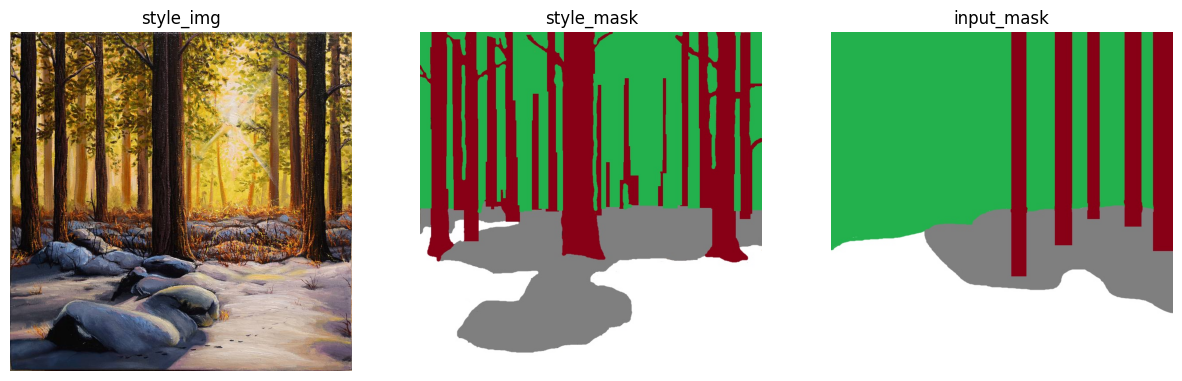

In [37]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title('style_img')
plt.axis('off')
plt.imshow(tensor_to_np(style_img))
plt.subplot(1,3,2)
plt.title('style_mask')
plt.axis('off')
plt.imshow(tensor_to_np(style_features))
plt.subplot(1,3,3)
plt.title('input_mask')
plt.axis('off')
plt.imshow(tensor_to_np(input_features))

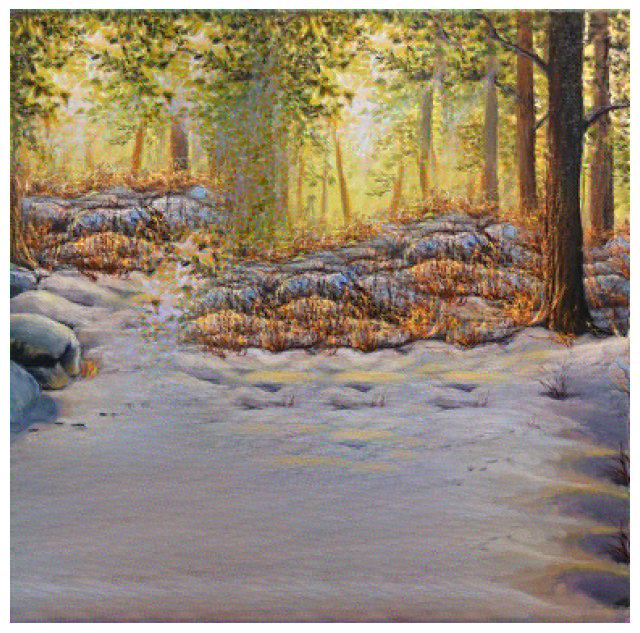

In [38]:
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(tensor_to_np(output))

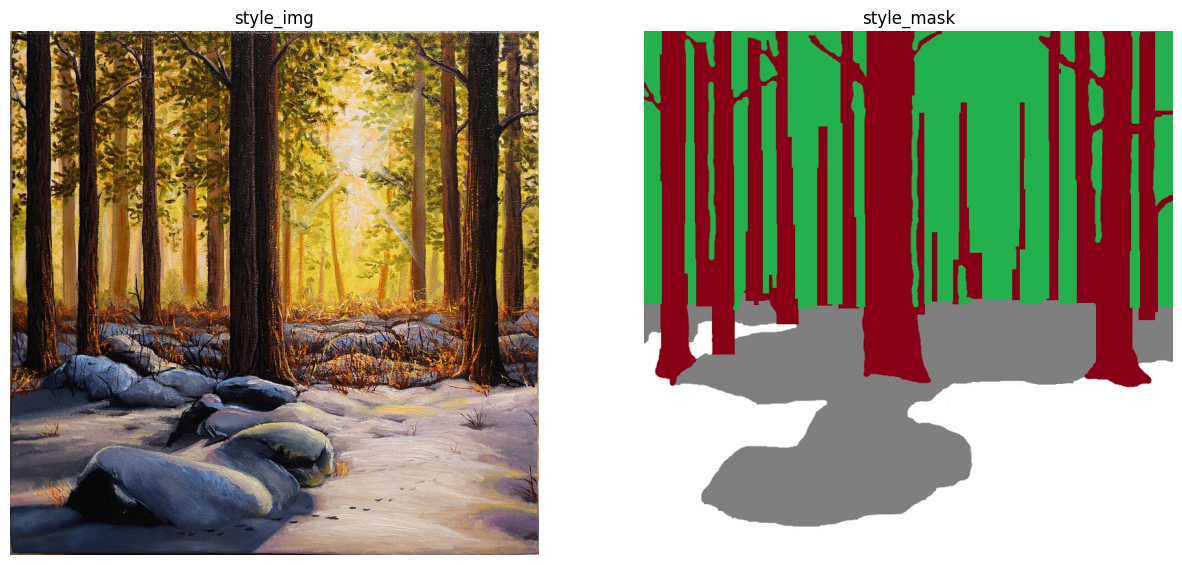

In [24]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('style_img')
plt.axis('off')
plt.imshow(tensor_to_np(style_img))
plt.subplot(1,2,2)
plt.title('style_mask')
plt.axis('off')
plt.imshow(tensor_to_np(style_features))

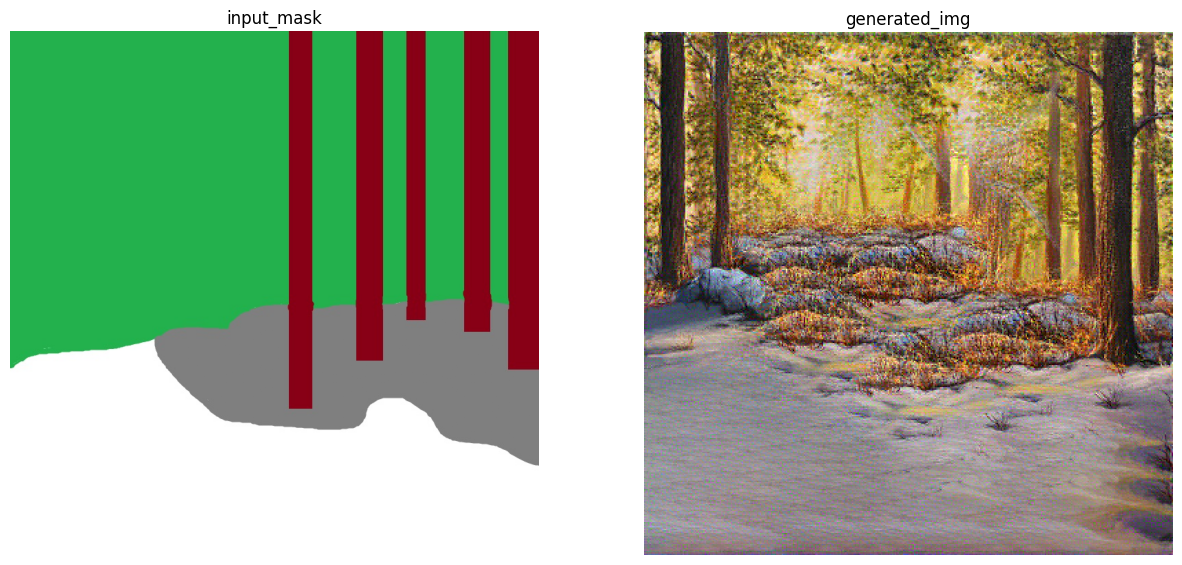

In [25]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('input_mask')
plt.axis('off')
plt.imshow(tensor_to_np(input_features))
plt.subplot(1,2,2)
plt.title('generated_img')
plt.axis('off')
plt.imshow(tensor_to_np(output))
# fig.savefig('doc2.jpg')